In [1]:
#%matplotlib inline
import matplotlib
import pylab
matplotlib.style.use('ggplot')

import getpass
from encrypt import decryptString, decryptCredentials
import psycopg2 as db
import psycopg2.extras
from psycopg2 import sql
import pprint


import gmaps
import gmaps.geojson_geometries
import geojson

import metnoRequests as metno

import ipywidgets as widgets
import traitlets
import IPython
from IPython.display import Javascript,display

def run_cell(idx) :
    display(Javascript('IPython.notebook.execute_cells([{}])'.format(idx))) 
    
def run_below() :
    Javascript('IPython.notebook.execute_cells_below()')     
    
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_cell(10)
        
#def list_select(change) :
#    if change['type']=='change' and change['name']=='value':
        #print('changed to {}'.format(change['new']))

def on_fetch(change) :
    if change['type']=='change' and change['name']=='value':
        run_cell(11)
        

# Automated data download from Meteorologisk Institutt

The purpose of this notebook is to document the routine to automatically download the freely available data from the Meteorologisk Institutt (metno).

The rationale is to download catchment-averaged (if possible) data. As such, it is first required to determine catchment boundaries. This is done with the [catchment delineation](https://github.com/Lecheps/Catchment_delineation) tool, also presented as a notebook. The catchment delineation tool (will eventually) allow to automatically delineate catchment in the whole norway, based on a coordinates only.
The results from the tool are stored as [Postgis](https://postgis.net/) objects in a [Postgresql](https://www.postgresql.org/) database.

Interaction with metno is done through their [frost.met.no api](https://frost.met.no/index.html).

In order to compute the catchment-averaged variables, data from stations within and at a certain distance from the catchment will be downloaded.

After running the catchment delineation tool, we need to interact with two of the generated tables. One storing the basins and one containing the stations. These, and the schema they belong to have to be explicitly defined.

In order to find the stations near the catchment we need to define a buffer around the catchment. Due to limitations to metno's api, this is currently a square surrounding it: the extent of the shapefile plus a buffer distance. This will be stored in a temporary table.

The downloaded datasets will be stored in the database and as python pickles (of a pandas dataframe).

In order to successfully run this notebook access to the database is needed as well as a client id from metno. The former is granted by whoever is a database administrator (currently JLG) and the other is [easily obtained in the metno site](https://data.met.no/auth/requestCredentials.html).

Some of the generated results will be displayed using the [gmaps](https://github.com/pbugnion/gmaps) package.
In order to use this it is necessary to get a google api key.

## Decrypting credentials for metno and the geodatabase

The credentials have been previously encrypted using the cryptography package. The encryption is performed in order not to expose the actual credentials on github.

In [2]:
metnoToken = b'gAAAAABaYEqld0O48m09jEyMUBFTdBmZA2BVey2r7FKbo_7zrJPOa1aEGcpW0WmnhGVJHYUPm32f8ttaiboXxAF-Q9hDat3lhsa4ELzrT6J_e402kRDmWi6k0kpldOC2LTBNM9vNLLF4'
databaseToken = b'gAAAAABaVgNb96o6n1Kixc3fHKQWyEPN7jnJvXv_NJs65yjvJDqZZOH4w9aTyYJD28kx3iJr4EG0nsqTgxv_PRCOPKjkGPlQHycz8BuRTr25vETKiPAbLT28CJWLYLnWMllF_M1sGj_GErPOciHOQiraNUuo6IJMlVnUVMR5FvhP7YtqCKwtLSk0yefn4HU2fc6I5x1NNd94'
apiToken = b'gAAAAABaXyLsGnF3ms4sC3ZhoLCwWAx9q0tydWl8XKEwOy8CO0W6Eqc8J4om8HNDlNR9nExYCmSrelp8W5R-PLtcce1I2UgW3YnlXXqWvrMN-outYwXhZoc59djfF752mzOPqXBHgpNC'

password = getpass.getpass('Password: ')

try :
    metnoKey = decryptString(metnoToken, password)
except :
    print("Wrong password (probably)")
        
try :
    credentials = decryptCredentials(databaseToken, password)
except :
    print("Wrong password (probably)")

try : 
    apiKey = decryptString(apiToken,password)
except :
    print("Wrong password (probably)")
        
    
gmaps.configure(api_key=apiKey)
metno.init(metnoKey,'https://frost.met.no')

del(password)

Password: ········


## Connecting to the database and creating buffer around basins

In [3]:
try : 
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                     credentials['username'],
                                                                     credentials['host'],
                                                                     credentials['password']
                                                                    )
                     )
except :
    print("Unable to connect")
    
cursor = conn.cursor()

# Hardcoding tables where the stations and basins were stored. These should already exist in the database.
schema = 'basins'
basinsTable = 'results32'
stationsTable = 'stations'

#Table where the buffered basins will be stored
resultsTable = 'bufferbasins'

#Getting epsg number for the basins in basinsTable
#The resulting epsg number should be a projected coordinate system with meters as the unit.
cursor.execute(sql.SQL("SELECT ST_SRID(a.basin) FROM {}.{} AS a WHERE sid = 1").format(sql.Identifier(schema),sql.Identifier(basinsTable)))
epsg_num = cursor.fetchone()[0]
conn.commit()

#Creating buffer around existing basins
bufferDistance = float(10000) #in meters

cursor.execute(sql.SQL(''' DROP TABLE IF EXISTS {0}.{1};
                           CREATE TABLE {0}.{1}(sid SERIAL PRIMARY KEY,
                                              station_id INTEGER UNIQUE ,
                                              station_name TEXT  UNIQUE ,
                                              buffer GEOMETRY(POLYGON,%s)
                                              );
                           
                           INSERT INTO {0}.{1}(station_id,station_name,buffer)
                           SELECT a.station_id,a.station_name,ST_Expand(a.basin,%s) 
                           FROM {0}.{2} AS a;
                           
                           SELECT a.station_name,ST_AsText(ST_Transform(a.buffer,4326)) FROM {0}.{1} AS a;
                           ''').format(sql.Identifier(schema),    #0
                                   sql.Identifier(resultsTable),  #1
                                   sql.Identifier(basinsTable) ), #2
                    (epsg_num,bufferDistance)
                   );

#Looping through all created buffers and storing polygons as WKT
rows = cursor.fetchall()
basin_polygons = {}
for row in rows:
    basin_polygons[row[0]] = row[1]
    
#Displaying polygons in gmaps. They need to be stored as a FeatureCollection
cursor.execute(""" SELECT json_build_object(
                    'type', 'FeatureCollection',

                    'features', json_agg(
                        json_build_object(
                            'type',       'Feature',
                            'label',       station_name,
                            'geometry',   ST_AsGeoJSON(ST_ForceRHR(st_transform(buffer,4326)))::json,
                            'properties', jsonb_set(row_to_json(bufferbasins)::jsonb,'{buffer}','0',false)                            
                             )
                        )
                   )
                    FROM basins.bufferbasins;
               """
              )


feature_collection=cursor.fetchone()[0]
buffer_layer = gmaps.geojson_layer(feature_collection)

fig = gmaps.figure()
fig.add_layer(buffer_layer)

fig

Figure()

## Finding metno stations within the buffer

Here, we first find if there are any stations within or near the basin according to the buffer defined in the above cell.

In order to get a better idea on the parameters of the search please refer to the [sources](https://data.met.no/reference#!/sources/getSources) section of _frost.met.no_

In [4]:
#datesToGet = '2007-01-01/2016-12-31'
datesToGet = '2015-01-01/2017-01-29'
stationsInBasin = {}
dataInStations = {}

for basin_name, polygon in basin_polygons.items() :
    stationsDict, requestReply = metno.getStationsInPolygon(polygon,datesToGet)
    stationsInBasin[basin_name] = stationsDict;
    print("Stations near {}: {}".format(basin_name, len(stationsDict) ) )
    stationIds = ','.join(i['id'] for i in stationsDict.values())
    dataInStations[basin_name] = metno.listAllTimeseries(stationIds,datesToGet)
    
#Displaying stations
cursor.execute(""" SELECT json_build_object(
                    'type', 'FeatureCollection',

                    'features', json_agg(
                        json_build_object(
                            'type',       'Feature',
                            'label',       station_name,
                            'geometry',   ST_AsGeoJSON(ST_ForceRHR(st_transform(basin,4326)))::json,
                            'properties', jsonb_set(row_to_json(results32)::jsonb,'{basin}','0',false)
                             )
                        )
                   )
                    FROM basins.results32;
               """
              )


layer=cursor.fetchone()[0]
fig = gmaps.figure()

basin_layer = gmaps.geojson_layer(layer)
fig.add_layer(basin_layer)


allStations = []
for key,value in stationsInBasin.items() :
    for k, v in value.items() :
        allStations.append( {"name" : k, "location" : v['coordinates'][::-1], "id" : v['id']} )

    
station_locations = [station["location"] for station in allStations]
#print(station_locations)
info_box_template = """
<dl>
<dt>Met station</dt><dd>{name}</dd>
<dt>id</dt><dd>{id}</dd>
</dl>
"""                                                
station_info = [info_box_template.format(**station) for station in allStations]                                                 
marker_layer = gmaps.marker_layer(station_locations, info_box_content=station_info)
fig.add_layer(marker_layer)

fig

Stations near Langtjern, utløp: 3
Stations near Storgama v. dam: 2
Stations near Birkenes: 2
Stations near Øygardsbekken: 4
Stations near Kårvatn: 1


Figure()

## Downloading data for a given station

Selecting basin to download data for.

In [5]:
w = widgets.Dropdown(
               options= [i for i in stationsInBasin],
               value = sorted(list(stationsInBasin.keys()))[0],
               description='Basin',
               disabled=False,
               )

In [6]:
display(w)
w.observe(on_change)

Dropdown(description='Basin', index=2, options=('Øygardsbekken', 'Langtjern, utløp', 'Birkenes', 'Storgama v. dam', 'Kårvatn'), value='Birkenes')

<IPython.core.display.Javascript object>

In [10]:
#Javascript('IPython.notebook.execute_selected_cells()')
print('Getting data for: {}'.format(w.value))
pprint.pprint(stationsInBasin[w.value])
variables = sorted([i['elementId'] + ' / ' + i['timeOffset'] + ' / ' + i['sourceId'][:-2] for i in dataInStations[w.value]])
#pprint.pprint(dataInStations[w.value])
list_widget = widgets.SelectMultiple(
    options=variables,
    #rows=10,
    description='Data',
    disabled=False,
    layout=widgets.Layout(width='auto', min_height='250px', align_items='stretch')
)

run_button = widgets.ToggleButton(
    value=True,
    description='Fetch boy!',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    #icon='check'
)


items = [
    list_widget,
    run_button
 ]

box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='100%')
box = widgets.Box(children=items, layout=box_layout)

display(box)
run_button.observe(on_fetch)

Getting data for: Langtjern, utløp
{'GULSVIK II': {'coordinates': [9.605, 60.383], 'id': 'SN24710'},
 'RV7 RALLERUD': {'coordinates': [9.8453, 60.2588], 'id': 'SN24240'},
 'RV7 ØVRE KRØDSHERAD': {'coordinates': [9.6923, 60.2685], 'id': 'SN24670'}}


Box(children=(SelectMultiple(description='Data', layout=Layout(align_items='stretch', min_height='250px', width='auto'), options=('accumulated(precipitation_amount) / PT00H / SN24710', 'air_temperature / PT18H / SN24240', 'air_temperature / PT18H / SN24670', 'air_temperature / PT18H / SN24710', 'dew_point_temperature / PT00H / SN24240', 'dew_point_temperature / PT00H / SN24670', 'dew_point_temperature / PT00H / SN24710', 'integral_of_deficit(mean(air_temperature P1D) P1M 17.0) / PT00H / SN24710', 'integral_of_deficit(mean(air_temperature P1D) P1Y 17.0) / PT00H / SN24710', 'integral_of_deficit(mean(air_temperature P1D) P3M 17.0) / PT00H / SN24710', 'integral_of_deficit(mean(air_temperature P1D) P6M 17.0) / PT00H / SN24710', 'integral_of_deficit(mean(air_temperature PT1H) P1D 17.0) / PT06H / SN24240', 'integral_of_deficit(mean(air_temperature PT1H) P1D 17.0) / PT06H / SN24710', 'integral_of_excess(mean(air_temperature P1D) P1D 0.0) / PT06H / SN24240', 'integral_of_excess(mean(air_temperature P1D) P1D 0.0) / PT06H / SN24710', 'integral_of_excess(mean(air_temperature P1D) P1D 5.0) / PT06H / SN24240', 'integral_of_excess(mean(air_temperature P1D) P1D 5.0) / PT06H / SN24710', 'integral_of_excess(mean(air_temperature P1D) P1M 0.0) / PT00H / SN24710', 'integral_of_excess(mean(air_temperature P1D) P1M 5.0) / PT00H / SN24710', 'max(air_temperature P1D) / PT00H / SN24710', 'max(air_temperature P1D) / PT18H / SN24710', 'max(air_temperature P1M) / PT18H / SN24710', 'max(air_temperature P1Y) / PT18H / SN24710', 'max(air_temperature P3M) / PT18H / SN24710', 'max(air_temperature P6M) / PT18H / SN24710', 'max(air_temperature PT12H) / PT18H / SN24710', 'max(air_temperature PT1H) / PT18H / SN24710', 'max(max(wind_speed P1D) P1M) / PT00H / SN24710', 'max(max(wind_speed PT1H) P1D) / PT06H / SN24710', 'max(relative_humidity P1D) / PT06H / SN24710', 'max(relative_humidity P1M) / PT00H / SN24710', 'max(sum(precipitation_amount P1D) P1M) / PT06H / SN24710', 'max(surface_snow_thickness P1M) / PT00H / SN24710', 'max(wind_speed P1D) / PT06H / SN24710', 'max(wind_speed P1M) / PT00H / SN24710', 'max(wind_speed PT1H) / PT00H / SN24710', 'max(wind_speed_of_gust P1D) / PT06H / SN24710', 'max(wind_speed_of_gust P1M) / PT00H / SN24710', 'max(wind_speed_of_gust PT1H) / PT00H / SN24710', 'max_wind_speed(wind_from_direction PT1H) / PT00H / SN24710', 'mean(air_temperature P1D) / PT06H / SN24710', 'mean(air_temperature P1D) / PT18H / SN24240', 'mean(air_temperature P1D) / PT18H / SN24710', 'mean(air_temperature P1M) / PT06H / SN24710', 'mean(air_temperature P1M) / PT18H / SN24710', 'mean(air_temperature P1Y) / PT18H / SN24710', 'mean(air_temperature P3M) / PT18H / SN24710', 'mean(air_temperature P6M) / PT18H / SN24710', 'mean(air_temperature_anomaly P1M 1961_1990) / PT18H / SN24710', 'mean(air_temperature_anomaly P1Y) / PT18H / SN24710', 'mean(air_temperature_anomaly P3M) / PT18H / SN24710', 'mean(air_temperature_anomaly P6M) / PT18H / SN24710', 'mean(dew_point_temperature P1D) / PT06H / SN24710', 'mean(dew_point_temperature P1M) / PT00H / SN24710', 'mean(max(air_temperature P1D) P1M) / PT18H / SN24710', 'mean(max(wind_speed P1D) P1M) / PT00H / SN24710', 'mean(max(wind_speed PT1H) P1D) / PT06H / SN24710', 'mean(min(air_temperature P1D) P1M) / PT18H / SN24710', 'mean(relative_humidity P1D) / PT06H / SN24710', 'mean(relative_humidity P1M) / PT00H / SN24710', 'mean(surface_snow_thickness P1M) / PT00H / SN24710', 'mean(water_vapor_partial_pressure_in_air P1D) / PT00H / SN24710', 'mean(water_vapor_partial_pressure_in_air P1M) / PT00H / SN24710', 'mean(wind_speed P1D) / PT06H / SN24710', 'mean(wind_speed P1M) / PT00H / SN24710', 'mean(wind_speed_of_gust P1D) / PT06H / SN24710', 'mean(wind_speed_of_gust P1M) / PT00H / SN24710', 'min(air_temperature P1D) / PT00H / SN24710', 'min(air_temperature P1D) / PT18H / SN24710', 'min(air_temperature P1M) / PT18H / SN24710', 'min(air_temperature P1Y) / PT18H / SN24710', 'min(air_temperature P3M) / PT18H / SN24710', 'min(air_temperatur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stations in Langtjern, utløp
Started download of mean(air_temperature P1D)  in  SN24710...
Done!
       mean(air_temperature P1D) 
count                  724.000000
mean                     5.390193
std                      8.269038
min                    -19.400000
25%                     -0.200000
50%                      4.800000
75%                     12.700000
max                     23.400000
Started download of mean(wind_speed P1D)  in  SN24710...
Done!
       mean(wind_speed P1D) 
count             723.000000
mean                1.534578
std                 0.739558
min                 0.400000
25%                 1.000000
50%                 1.400000
75%                 1.900000
max                 5.100000
Started download of relative_humidity  in  SN24710...
Done!
       relative_humidity 
count        17605.000000
mean            74.261346
std             20.108972
min             12.000000
25%             61.000000
50%             81.000000
75%             91.000000
max  

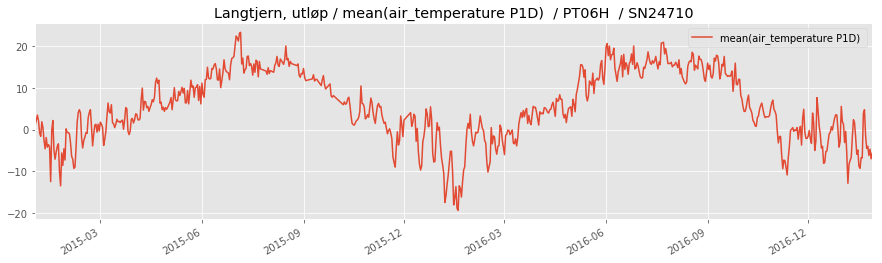

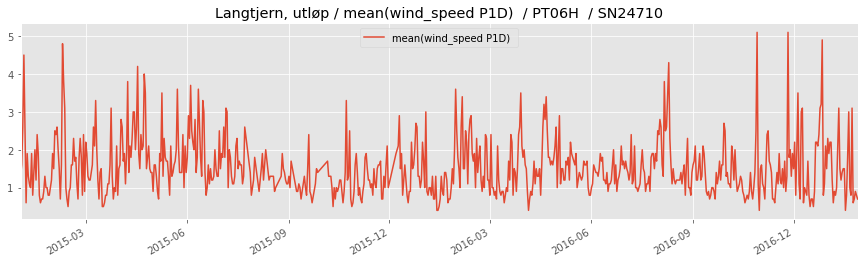

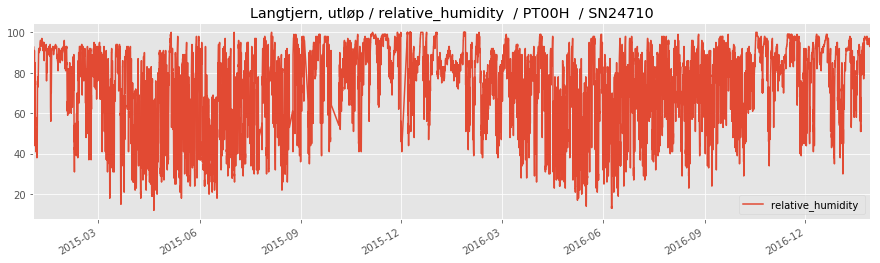

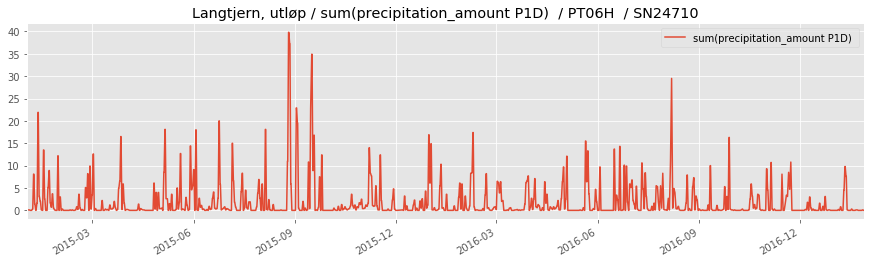

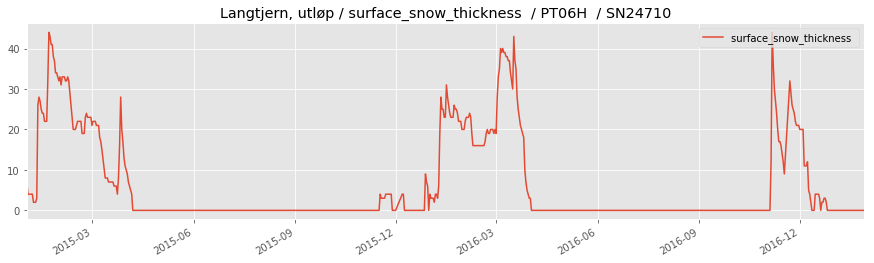

In [18]:
variableList = [i.split('/') for i in list(list_widget.value)]
print('Stations in {}'.format(w.value))
pylab.rcParams['figure.figsize'] = (15, 4)
for row in variableList :
    df,junk = metno.downloadData(row[2],row[0],row[1],datesToGet)
    print(df.describe())
    df.plot(title=w.value + ' / ' + ' /'.join(row))

#pprint.pprint(junk)
    

In [9]:
conn.close()